# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [1]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't have an associated intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [2]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [3]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

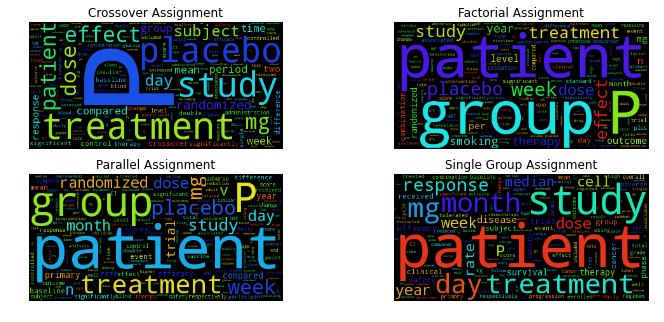

In [4]:
from support import word_cloud

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Train Test Split

In [5]:
from sklearn.cross_validation import train_test_split

abstracts_train, abstracts_test, ys_train, ys_test = train_test_split(df.abstract, df.intervention_model)

abstracts_train.shape, abstracts_test.shape, ys_train.shape, ys_test.shape

((1563,), (522,), (1563,), (522,))

### Vectorize Train and Test Abstracts

Make sure to only fit the training set and **not** the test set!

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vectorizer.fit(abstracts_train)

X_train, X_test = vectorizer.transform(abstracts_train), vectorizer.transform(abstracts_test)

X_train.shape

(1563, 171205)

### Extract and Order Vocabulary

In [184]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Hyperparameters

In [185]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

M, N = X_train.shape
K = 3 # number of folds for cross-validation

# a priori best hyperparameters
default_alpha = 0.001
default_n_iter = int(np.ceil(10**6/(M-M/K))) # http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

def search_params(clf, parameters, X_train=abstracts_train, ys_train=ys_train, verbose=3, scoring='f1_macro', k=5):
    """Perform a grid search over the parameters
    
    k: the number of folds to be used for cross-validation
    
    """
    grid_search = GridSearchCV(clf, parameters, verbose=verbose, scoring=scoring, cv=k)
    grid_search.fit(X_train, ys_train)
    
    return grid_search

### Search

#### Observations

- Running SGD for 1M runs is sufficient and `n_iter` is set accordingly
- Using `TF-IDF` always performs worse than using binary features
- The best alpha is somewhere between `np.logspace(-1, -5)`

In [202]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', binary=True)),
    ('clf', SGDClassifier(class_weight='auto', n_iter=default_n_iter)),
])

parameters = {
    'tfidf__use_idf': (True, False),
    'clf__alpha': np.logspace(-1.5, -3.5, 10)
}

grid_search = search_params(pipeline, parameters, k=K)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] tfidf__use_idf=True, clf__alpha=0.0316227766017 .................
[CV]  tfidf__use_idf=True, clf__alpha=0.0316227766017, score=0.508460 -   4.1s
[CV] tfidf__use_idf=True, clf__alpha=0.0316227766017 .................
[CV]  tfidf__use_idf=True, clf__alpha=0.0316227766017, score=0.492597 -   4.0s
[CV] tfidf__use_idf=True, clf__alpha=0.0316227766017 .................
[CV]  tfidf__use_idf=True, clf__alpha=0.0316227766017, score=0.450251 -   4.1s
[CV] tfidf__use_idf=False, clf__alpha=0.0316227766017 ................
[CV]  tfidf__use_idf=False, clf__alpha=0.0316227766017, score=0.463908 -   3.9s
[CV] tfidf__use_idf=False, clf__alpha=0.0316227766017 ................
[CV]  tfidf__use_idf=False, clf__alpha=0.0316227766017, score=0.464460 -   4.0s
[CV] tfidf__use_idf=False, clf__alpha=0.0316227766017 ................
[CV]  tfidf__use_idf=False, clf__alpha=0.0316227766017, score=0.448059 -   4.0s
[CV] tfidf__use_idf=True, clf__alpha

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:  2.1min



[CV] tfidf__use_idf=True, clf__alpha=0.00244843674682 ................
[CV]  tfidf__use_idf=True, clf__alpha=0.00244843674682, score=0.623423 -   4.0s
[CV] tfidf__use_idf=False, clf__alpha=0.00244843674682 ...............
[CV]  tfidf__use_idf=False, clf__alpha=0.00244843674682, score=0.549576 -   3.8s
[CV] tfidf__use_idf=False, clf__alpha=0.00244843674682 ...............
[CV]  tfidf__use_idf=False, clf__alpha=0.00244843674682, score=0.616569 -   4.0s
[CV] tfidf__use_idf=False, clf__alpha=0.00244843674682 ...............
[CV]  tfidf__use_idf=False, clf__alpha=0.00244843674682, score=0.632495 -   3.9s
[CV] tfidf__use_idf=True, clf__alpha=0.00146779926762 ................
[CV]  tfidf__use_idf=True, clf__alpha=0.00146779926762, score=0.543723 -   3.9s
[CV] tfidf__use_idf=True, clf__alpha=0.00146779926762 ................
[CV]  tfidf__use_idf=True, clf__alpha=0.00146779926762, score=0.630705 -   3.9s
[CV] tfidf__use_idf=True, clf__alpha=0.00146779926762 ................
[CV]  tfidf__use_id

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.9min finished


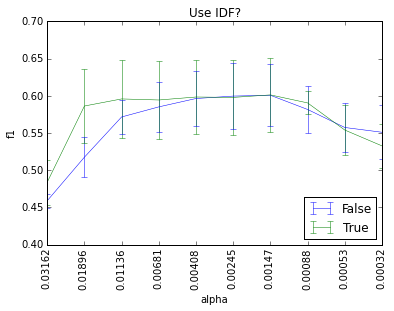

In [204]:
# Get scores for different hyperparam settings into dataframe
df = pd.DataFrame(grid_search.grid_scores_, columns=grid_search.grid_scores_[0]._fields)

# Explode cv scores for each hyperparam setting
scores = df.cv_validation_scores.apply(pd.Series)
scores = scores.rename(columns=lambda x: 's{}'.format(x))
score_columns = scores.columns

scores['f1'], scores['err'] = scores.mean(axis=1), scores.std(axis=1) # mean f1 and stddev for cv scores

hyperparams = df.parameters.apply(lambda x: pd.Series(x))

df = pd.concat([hyperparams, scores], axis=1).fillna(0) # concatenate the two back together

groups = df.groupby('tfidf__use_idf') # consider norm groups independently

axes = None
for i, group in groups:
    group = group.reset_index() # so the two plots line up on top of each other and not in lockstep
    axes = group.f1.plot(yerr=group.err, linewidth=.5, label=group.tfidf__use_idf[0]) # plot f1 average with error bars

# axes
alphas = df.clf__alpha.unique().round(5)
tick_marks = np.arange(len(alphas))
plt.xticks(tick_marks, alphas, rotation=90)
axes.set_xlabel('alpha')
axes.set_ylabel('f1')
plt.legend(loc='lower right')
plt.title('Use IDF?')

### Best `(clf, tf-idf)` Pair

In [205]:
best_clf, best_tfidf = grid_search.best_estimator_.named_steps['clf'], grid_search.best_estimator_.named_steps['tfidf']

grid_search.best_score_

0.60104273708880318

In [206]:
best_tfidf

TfidfVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [207]:
best_clf

SGDClassifier(alpha=0.0014677992676220704, average=False, class_weight='auto',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=959, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

### Prediction on Test Set

In [208]:
X_test = best_tfidf.transform(abstracts_test) # vectorize test set with best TF-IDF and predict with best alpha
predictions = best_clf.predict(X_test)

# Compute f1s for all classes
import sklearn
lb = sklearn.preprocessing.LabelBinarizer()
f1s = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)

# Display f1s
import re
from collections import namedtuple
Classes = namedtuple('Classes', map(lambda s: re.sub('\s+', '_', s), best_clf.classes_))

print 'f1s: {}'.format({label: f1 for label, f1 in zip(best_clf.classes_, f1s)})
print
print 'Average: {}'.format(np.mean(f1s))

f1s: {'Factorial Assignment': 0.36842105263157893, 'Parallel Assignment': 0.87444608567208271, 'Crossover Assignment': 0.65979381443298968, 'Single Group Assignment': 0.76724137931034486}

Average: 0.667475583012


### Confusion Matrix

#### Observations

- Crossover assignment is often confused as parallel assignment. This makes sense as there are multiple groups, just as in parallel assignment
- Factorial assignment f1 is very low because we just don't have enough data for them. In the word clouds below, you can see *adhd* as being the most strongly correlated unigram with factorial assignments, instead of *combination*, which makes more sense
- Parallel assignment is often classified correctly. The model confuses parallel and single groups

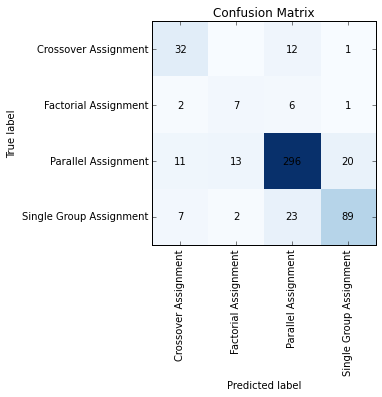

In [209]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = best_clf.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

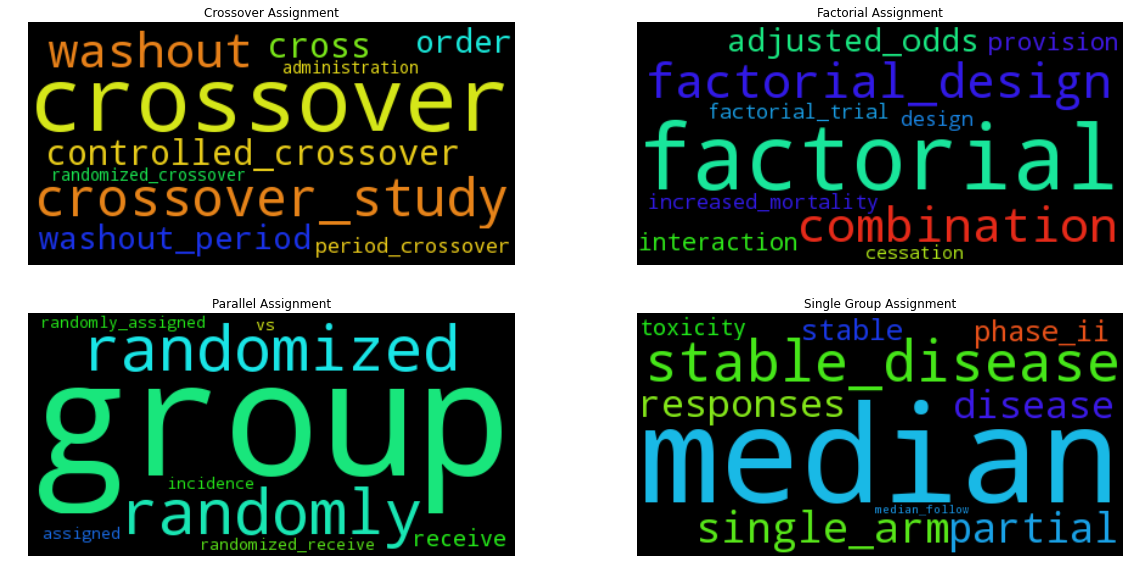

In [210]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(best_clf.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()